# Vision Transformer (ViT)

El Vision Transformer (ViT), propuesto por Dosovitskiy et al. (2020), utiliza una arquitectura basada en Transformers para tareas de visión por computadora. A diferencia de las CNN, el ViT aplica **Multi-Head Self-Attention (MHSA)** para modelar relaciones globales entre partes de la imagen.

## Arquitectura

El ViT divide las imágenes en **patches** y las convierte en una secuencia de vectores de características (embeddings), que luego se procesan mediante capas Transformer. A continuación, se aplica el mecanismo de self-attention para modelar las relaciones entre estos patches.

- **Embeddings**: Cada parche se aplana y se proyecta en un espacio de mayor dimensión.
- **Positional Encoding**: Se agrega un embebido posicional para cada parche, permitiendo que el modelo capture las posiciones espaciales.
---
## ¿Cómo funciona el Self-Attention en ViT?

Cada uno de los parches se considera un token similar a las palabras en el procesamiento del lenguaje natural (NLP).
En el mecanismo de Self-Attention, cada uno de estos tokens (parches) puede interactuar con los demás tokens. Para hacerlo, el modelo calcula tres vectores para cada token:

- **Query:** Representa qué está buscando el token.

- **Key:** Representa una descripción de los demás tokens.

- **Value:** Es la información que tiene cada token y que podría ser relevante para otros tokens.

Luego, se calculan las similitudes entre el *Query* de un token y el *Key* de todos los demás tokens, lo que genera una "puntuación de atención". Esta puntuación determina cuánta atención debe prestar un token a otros. El valor *Value* de cada token se pondera según esta puntuación, lo que permite que un token integre información de todo el resto de la imagen.

Este mecanismo es lo que permite que cada token (parche) en una imagen entienda no solo lo que está ocurriendo en su área local, sino también pueda considerar qué está sucediendo en otras partes de la imagen.

La fórmula utilizada para calcular la atención es:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Donde:
- **$Q$ (queries)**, **$K$ (keys)**, y **$V$ (values)** son las proyecciones lineales de los embeddings de los patches.
- **$d_k$** es la dimensionalidad de las proyecciones, usada para escalar el producto punto y estabilizar el entrenamiento.

Este proceso se aplica en múltiples cabezas, lo que permite al modelo aprender distintas representaciones.

El mecanismo de self-attention utiliza las proyecciones:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

Donde $X$ es el input y $W_Q$, $W_K$, y $W_V$ son matrices de pesos aprendidos.

Después de aplicar el mecanismo de Self-Attention, los tokens se actualizan, ya que ahora tienen información de los demás tokens. Este proceso se repite varias veces en distintas capas de atención, profundizando la interacción entre los parches.

Salida Final: Después de aplicar múltiples capas de Self-Attention, el modelo agrupa los tokens procesados para predecir la clase de la imagen o realizar otras tareas de visión.


<img src="vit_gif.gif" alt="Vision Transformer" width="400" height="300">

*Crédito: [lucidrains](https://github.com/lucidrains/vit-pytorch)*

## Tareas:

1. **Implementar la arquitectura de un Vision Transformer**

2. **Ingresar y ajustar los parametros del modelo**

3. **Probar diferentes técnicas de data augmentation**

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer
from torch.optim.lr_scheduler import CosineAnnealingLR

In [29]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches


class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()

        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

        nn.init.trunc_normal_(self.pos_embedding, std=0.02)

    def forward(self, x):
        return x + self.pos_embedding



Dispositivo:  cuda
Torch version:  2.5.0+cu118


In [28]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout,activation='gelu',bias= False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

### Arquitectuta de Vision Transformer

In [27]:
class VisionTransformer(nn.Module):

    def __init__(self, img_size: int, 
                 patch_size: int,
                 embed_dim: int, 
                 num_heads: int, 
                 ff_dim: int, 
                 num_layers: int, 
                 dropout: float, 
                 batch_first: bool):
        
        super(VisionTransformer, self).__init__()

        # cantidad de parches
        self.num_patches = (img_size // patch_size) ** 2

        # 1. division y aplanado - Proyección de parches
        self.patch_embedding = PatchEmbedding(img_size, patch_size, 3, embed_dim)


        # 2. codificacion posicional y aprendizaje (learning)
        self.positional_encoding = PositionalEncodingLearned(self.num_patches , embed_dim)

        # 3. capas de codificador de transformer
        self.transformer = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout)
        
        # 4. head MLP
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 10)
        )


    def forward(self, x):

        x = self.patch_embedding(x)  # (B, num_patches, embed_dim)

        # Añadir embeddings posicionales
        x = self.positional_encoding(x)

        # Pasar por el Transformer Encoder
        x = self.transformer(x)

        x = x.mean(dim=1)

        # Clasificación
        x = self.mlp_head(x)
        return x

In [5]:
#torch.autograd.set_detect_anomaly(True)

### Procesamiento de DATASET

In [6]:
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
    ])

# Datasets
train_dataset = datasets.CIFAR10(root='data', train=True, transform=transform, download=False)
test_dataset = datasets.CIFAR10(root='data', train=False, transform=transform, download=False)

# DataLoaders (nota el uso de num_workers > 0)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=2)


### Definir parametros

In [7]:
num_epochs = 10

model = VisionTransformer(img_size=32, 
                          patch_size=4, 
                          embed_dim=64,
                          num_heads=8,
                          ff_dim=256,
                          num_layers=6,
                          dropout=0.1,
                          batch_first=True).to(device)


print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

c:\Users\PC-01\Documents\ENTORNOS_PYTHON\venvi_pytorch118\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[-0.0034,  0.0883,  0.0107, -0.0559],
          [ 0.1052,  0.0888,  0.0506, -0.0851],
          [-0.1332,  0.0308, -0.0705,  0.1078],
          [ 0.0160, -0.0363,  0.1003, -0.0950]],

         [[ 0.0246,  0.1028, -0.0934,  0.0409],
          [-0.1332, -0.0782,  0.1210,  0.0182],
          [ 0.0503,  0.0439,  0.0998, -0.1415],
          [-0.1076,  0.0868, -0.1109, -0.1144]],

         [[-0.0940, -0.0040, -0.0022, -0.0391],
          [ 0.0313, -0.0255,  0.0601, -0.1025],
          [-0.0150,  0.0905,  0.0008,  0.0267],
          [ 0.1059,  0.0783, -0.0094,  0.0277]]],


        [[[ 0.0490,  0.1381,  0.0170, -0.1080],
          [-0.0797,  0.1165,  0.0782,  0.0740],
          [-0.1101,  0.0311, -0.0335,  0.0284],
          [-0.1021,  0.1231, -0.0553,  0.1112]],

         [[-0.0406, -0.1259, -0.0715,  0.0218],
          [ 0.0621,  0.1143,  0.1267,  0.0555],
          [-0.0767,  0.0324,  0.1252, -0.1148],
          [-0.0023,  0.0221,  0.

In [8]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))

Número de parámetros: 0.30 millones


### Entrenamiento

In [9]:
trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)

for epoch in range(num_epochs):
    trainer.train_model(use_amp=True)

  0%|          | 0/98 [00:00<?, ?it/s]c:\Users\PC-01\Documents\ENTORNOS_PYTHON\venvi_pytorch118\lib\site-packages\torch\autograd\graph.py:825: UserWarning: cuDNN SDPA backward got grad_output.strides() != output.strides(), attempting to materialize a grad_output with matching strides... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\MHA.cpp:676.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
loss 1.02431: 100%|██████████| 98/98 [00:08<00:00, 12.02it/s]


In [10]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return accuracy, precision, recall, f1

# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

100%|██████████| 20/20 [00:04<00:00,  4.21it/s]

Accuracy: 0.63
Precision: 0.62
Recall: 0.63
F1 score: 0.62


In [11]:
train_dataset.data[0].shape

(32, 32, 3)

In [13]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

  0%|          | 0/20 [00:04<?, ?it/s]


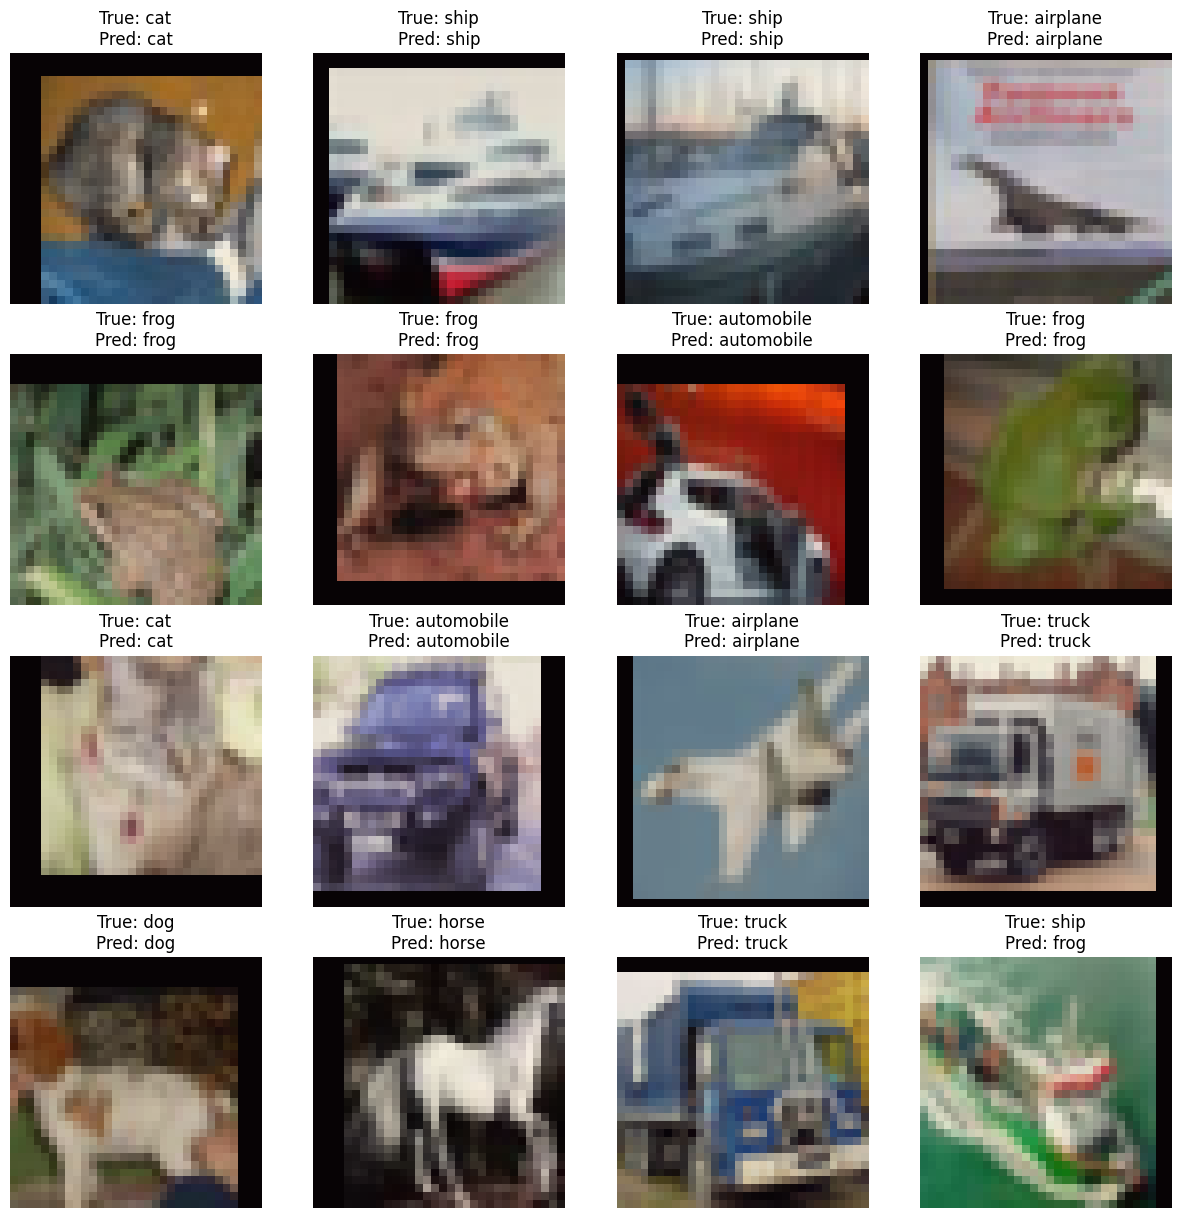

In [14]:
def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return


visualize_classification(model, test_loader, class_names, num_images=16)
plt.show()

### Introduciendo transformaciones para data augmentation

In [30]:
transform = transforms.Compose([
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
    ])

# Datasets
train_dataset = datasets.CIFAR10(root='data', train=True, transform=transform, download=False)
test_dataset = datasets.CIFAR10(root='data', train=False, transform=transform, download=False)

# DataLoaders (nota el uso de num_workers > 0)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=2)

In [31]:
num_epochs = 10

model = VisionTransformer(img_size=32, 
                          patch_size=4, 
                          embed_dim=64,
                          num_heads=8,
                          ff_dim=256,
                          num_layers=6,
                          dropout=0.1,
                          batch_first=True).to(device)


print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)

for epoch in range(num_epochs):
    trainer.train_model(use_amp=True)

Parametros del modelo: [Parameter containing:
tensor([[[[-0.0230,  0.0149,  0.1339,  0.0581],
          [-0.0886, -0.0922, -0.0095,  0.1125],
          [ 0.0579, -0.0011,  0.0017, -0.0483],
          [-0.0999,  0.0407,  0.0984, -0.1008]],

         [[ 0.0420,  0.0405, -0.1216,  0.0361],
          [-0.1223,  0.0255,  0.0467, -0.0117],
          [ 0.1188, -0.0735, -0.0037,  0.1026],
          [-0.1114, -0.0303,  0.0177, -0.0033]],

         [[ 0.0094,  0.0787, -0.1060,  0.1138],
          [ 0.1342, -0.1392, -0.0168, -0.0728],
          [ 0.0608,  0.0590,  0.1167,  0.0551],
          [-0.0289, -0.0087, -0.0087, -0.1022]]],


        [[[-0.0350,  0.1426,  0.0304, -0.0953],
          [ 0.0819, -0.0746,  0.0596,  0.0984],
          [-0.1186,  0.1143, -0.0931,  0.0248],
          [ 0.1202, -0.1171, -0.0875, -0.0430]],

         [[ 0.1221, -0.1336, -0.1159,  0.0374],
          [ 0.0056,  0.0889,  0.0472,  0.0159],
          [ 0.1109,  0.0117, -0.0792, -0.1151],
          [ 0.0873,  0.0077,  0.

loss 1.28727: 100%|██████████| 98/98 [00:15<00:00,  6.50it/s]


In [32]:

# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

100%|██████████| 20/20 [00:06<00:00,  3.28it/s]

Accuracy: 0.53
Precision: 0.54
Recall: 0.53
F1 score: 0.53


  0%|          | 0/20 [00:04<?, ?it/s]


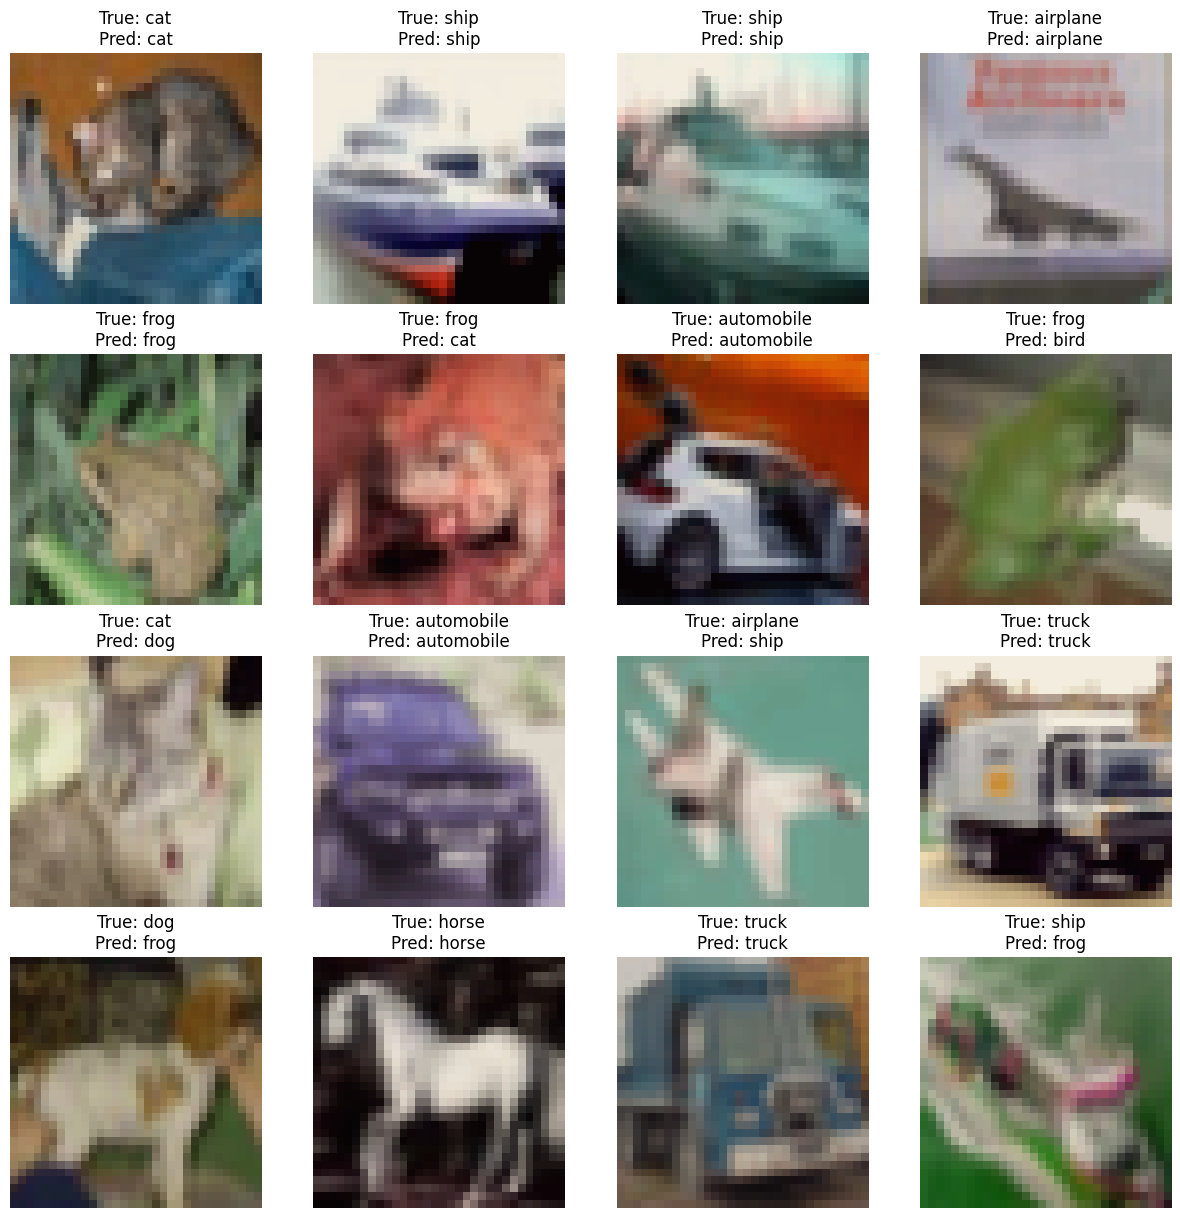

In [33]:
visualize_classification(model, test_loader, class_names, num_images=16)
plt.show()

### Conclusiones

- De la arquitectura ViT se observa un rendimiento aceptable para un modelo no preentrenado, y se valida el funcionamiento de la arquitectura. 

- El incremento de parámetros en la arquitectura ViT aumenta su complejidad computacional, por lo tanto demanda mayores recursos de procesamiento y memoria para su entrenamiento.

- Se ingresó parámetros en la transformada con variación de color y rotación de la imagen, esto evidencia en el entrenamiento un aprendizaje mas lento.

